In [2]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as wb 
import requests
import zipfile as zi 
import io
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index

# We will use SPX

In [4]:
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()

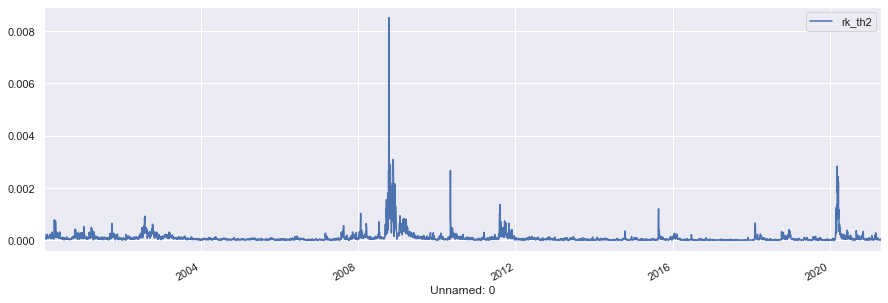

In [5]:
rv1.plot(figsize=(15,5))

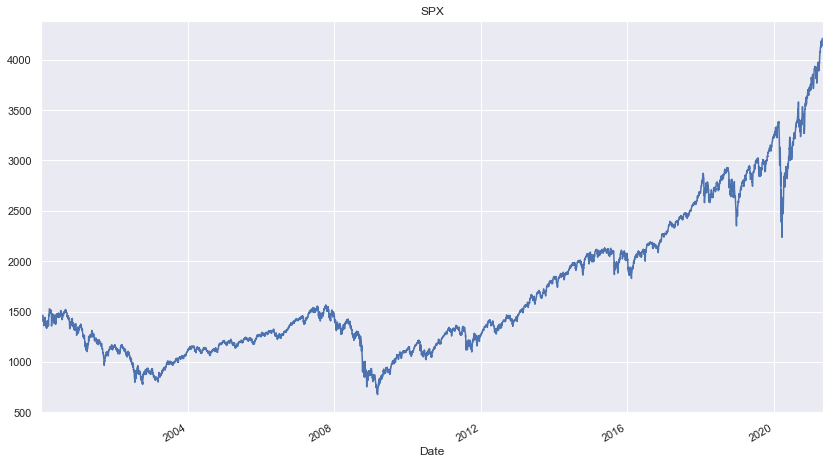

In [6]:
SPX = wb.DataReader(name = '^GSPC',data_source = 'yahoo', start='2000-01-01')
SPX = SPX['Adj Close']
SPX.plot(title='SPX',figsize=(14, 8));

In [7]:
spx = rv1 
spx['sqrt']= np.sqrt(spx['rk_th2'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

[0.08397519061943558, 0.16751519336448562, 0.25082211547343863, 0.33409727761003855, 0.5009887333983462]


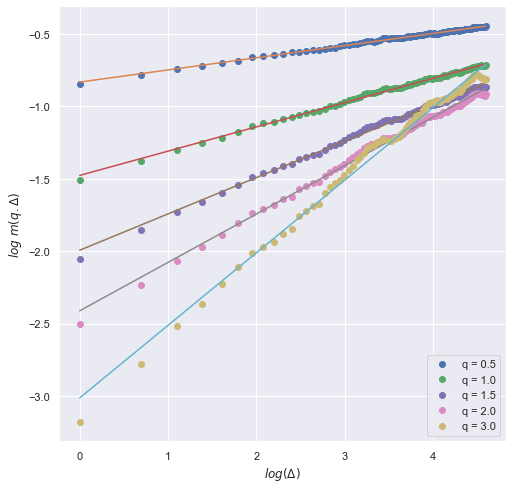

In [8]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o',label = 'q = {}'.format(q)) 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1) 
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    plt.legend()
    
print(zeta_q)

0.16673463661615234 1.0003421327623971


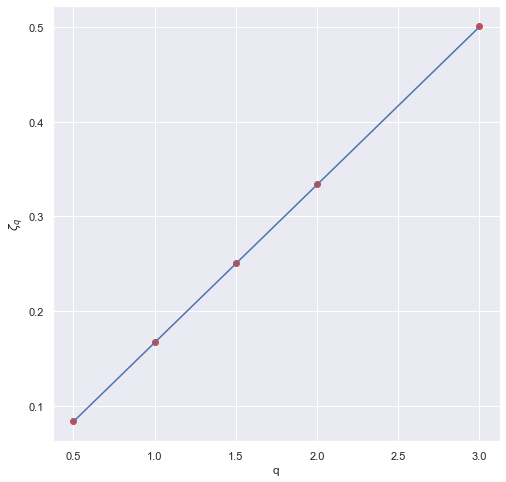

In [9]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec)
h_est= line[0]
nu = np.sqrt(np.exp(line[1]))
print(h_est,nu)

In [10]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(rvdata.truncate(after=date))
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return np.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [11]:
df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
rvdata = rv1.drop(['Symbol'],axis = 1)

In [12]:
nu  = nu # Vol of vol estimate for SPX
h = h_est
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values
rv_actual.reshape(1,len(rv_actual))
rv_predict = np.array(rv_predict)

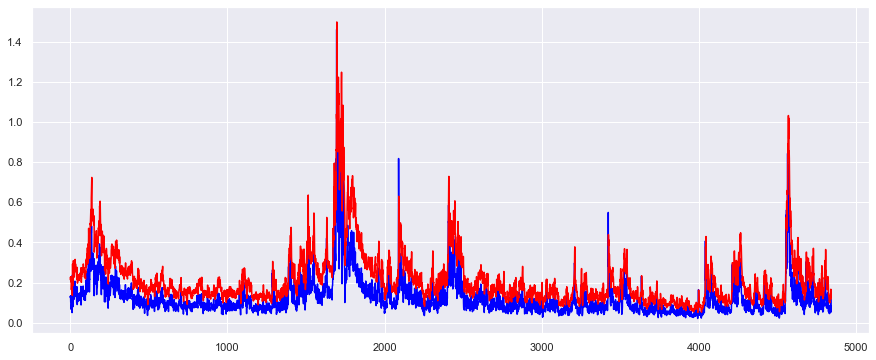

In [13]:
plt.figure(figsize=(15, 6))
vol_actual = np.sqrt(rv_actual * 252 ) 
vol_predict = np.sqrt(rv_predict * 252)
plt.plot(vol_actual,color = "blue")
plt.plot(vol_predict,color = "red")
plt.show()

# Generate Franctional Browenian Motions 

# Using Cholesky decomposition

In [377]:
from scipy import linalg
import numba 
from numba import jit
empty_mt = np.zeros(1000*1000).reshape(1000,1000)
H = 0.01

In [369]:
t1 = np.linspace(0.001,5,1000)
t2 = np.linspace(0.001,5,1000)

In [415]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def autocov(t1,t2,empty_mt,n):
    for m in range(n):
        l = t2[m] 
        for i in range(n): 
            x = t1[i]
            empty_mt[i,m] = .5 * (x**(2*H) + l**(2*H) - np.abs(x-l)**(2*H))
    return empty_mt

CPU times: user 327 µs, sys: 13 µs, total: 340 µs
Wall time: 347 µs


In [417]:
%%time
df = autocov(t1,t2,empty_mt,len(t2))

CPU times: user 46.8 ms, sys: 224 µs, total: 47 ms
Wall time: 47 ms


In [438]:
M = 100000
Lower_mt = linalg.cholesky(df, lower=True)
rnd = np.random.normal(size=(M,len(t1)))
arr = np.ones(100000 * len(t1)).reshape(100000,len(t1))

-0.199552133527541

In [451]:
@jit(nopython=True, parallel=True,fastmath=True)
def Generate_MC(Lower_mt,rnd,M,arr):
    for i in numba.prange(M):
        arr[i,:] = Lower_mt @ rnd[i,:]
    return arr
        

In [452]:
%%time
b = Generate_MC(Lower_mt,rnd,100000,arr)

KeyboardInterrupt: 

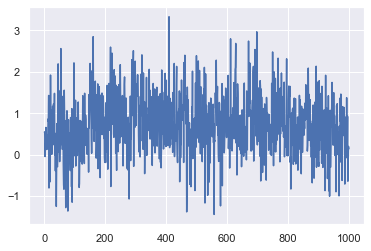

In [457]:
plt.plot(b[100,:])

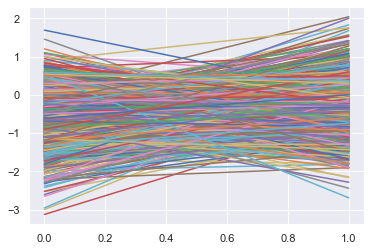

In [462]:
plt.plot(b[:2,:])

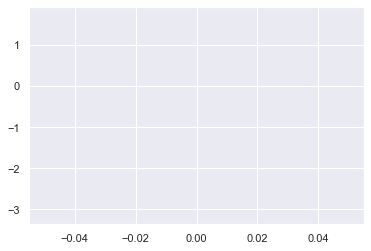

In [468]:
plt.plot(b[:1,:])

In [405]:
Lower_mt = linalg.cholesky(df, lower=True)
W_h_t = {} 
for i in range(100):
    W_h_t[i] = np.dot(Lower_mt,np.random.normal(0,1,1000).reshape(1000,1))

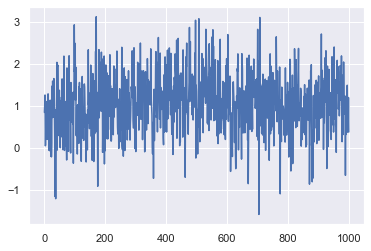

In [414]:
plt.plot(W_h_t[99])

In [444]:
arr = np.ones(100000 * len(t1)).reshape(100000,len(t1))

In [441]:
100000 * len(t1)

100000000

# Using Eigenvectors Decomposition

In [426]:
rnd = np.random.normal(size=(100000,len(t1)))

In [428]:
len(rnd)

100000

In [275]:
H = 0.10
def _autocovariance(k):
        """Autocovariance for fgn."""
        return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) + abs(k + 1) ** (2 * H))
row_component = [_autocovariance(i) for i in range(1, 1000)]
reverse_component = list(reversed(row_component))
row = [_autocovariance(0)] + row_component + [0] + reverse_component

In [281]:
eig = np.fft.fft(row).real
ev = np.sqrt(eig)
len(ev)

2000

In [311]:
Z = np.random.normal(0,1,2000).reshape(2000,1)
DFT = np.fft.fft(Z).real
a2 = np.fft.fft(np.dot(ev,DFT))
a1 = eig_vectors * a2 /(len(eig_vectors) + 1)

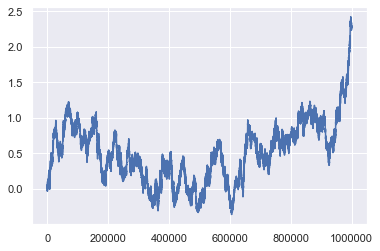

In [312]:
plt.plot((a1.reshape(1,1000000)[0]).real.cumsum())

In [212]:
empty_mt = np.zeros(1000*1000).reshape(1000,1000)
t1 = np.linspace(0,4,1000)
t2 = np.linspace(0,4,1000)
H = 0.99
dt = 4/1000

In [235]:
%%time
for m,l in enumerate(t2):
    empty_mt[:,m] = [.5 * ((np.abs(x-l) + dt)**(2*H) + (2 * np.abs(x-l))**(2*H) + np.abs(abs(x-l) - dt)**(2*H)) for x in t1]

CPU times: user 5.18 s, sys: 14.6 ms, total: 5.19 s
Wall time: 5.22 s


In [236]:
circl = linalg.circulant(empty_mt[:,0])

In [237]:
circl

array([[1.78681168e-05, 4.62589461e+01, 4.61673067e+01, ...,
        4.85511904e-04, 2.27044357e-04, 7.05933179e-05],
       [7.05933179e-05, 1.78681168e-05, 4.62589461e+01, ...,
        8.45062089e-04, 4.85511904e-04, 2.27044357e-04],
       [2.27044357e-04, 7.05933179e-05, 1.78681168e-05, ...,
        1.30508593e-03, 8.45062089e-04, 4.85511904e-04],
       ...,
       [4.60757572e+01, 4.59842977e+01, 4.58929282e+01, ...,
        1.78681168e-05, 4.62589461e+01, 4.61673067e+01],
       [4.61673067e+01, 4.60757572e+01, 4.59842977e+01, ...,
        7.05933179e-05, 1.78681168e-05, 4.62589461e+01],
       [4.62589461e+01, 4.61673067e+01, 4.60757572e+01, ...,
        2.27044357e-04, 7.05933179e-05, 1.78681168e-05]])

In [238]:

eig_values,eig_vectors = linalg.eig(circl)
eig_values

array([ 1.55307606e+04+0.00000000e+00j,  2.29065177e+03+7.39496081e+03j,
        2.29065177e+03-7.39496081e+03j,  5.56555765e+02+3.69132451e+03j,
        5.56555765e+02-3.69132451e+03j,  2.34690546e+02+2.45988213e+03j,
        2.34690546e+02-2.45988213e+03j,  1.21936657e+02+1.84458377e+03j,
        1.21936657e+02-1.84458377e+03j,  6.97222111e+01+1.47550864e+03j,
        6.97222111e+01-1.47550864e+03j,  4.13500249e+01+1.22949087e+03j,
        4.13500249e+01-1.22949087e+03j,  2.42388216e+01+1.05377435e+03j,
        2.42388216e+01-1.05377435e+03j,  1.31312418e+01+9.21989386e+02j,
        1.31312418e+01-9.21989386e+02j,  5.51500111e+00+8.19489153e+02j,
        5.51500111e+00-8.19489153e+02j,  6.66276831e-02+7.37486754e+02j,
        6.66276831e-02-7.37486754e+02j, -3.96486554e+00+6.70391084e+02j,
       -3.96486554e+00-6.70391084e+02j, -7.03134395e+00+6.14475015e+02j,
       -7.03134395e+00-6.14475015e+02j, -9.41791439e+00+5.67158371e+02j,
       -9.41791439e+00-5.67158371e+02j, -1.13116725

In [231]:
ev = abs(eig_values)**(1/2)

In [232]:
Z = np.random.normal(0,1,1000).reshape(1000,1)
DFT = scipy.fft.ifft(Z).real
DFT

array([[ 2.38603821e-01],
       [ 3.61694440e-01],
       [ 1.57834156e+00],
       [-4.74501734e-01],
       [ 5.57702761e-01],
       [ 1.56303047e+00],
       [-1.26849843e+00],
       [ 2.42300940e-01],
       [-6.22229756e-01],
       [-2.39049434e-01],
       [-2.91213367e-01],
       [-8.48198866e-02],
       [ 7.86442101e-01],
       [ 1.10299615e+00],
       [ 1.13712194e-01],
       [-5.85095602e-01],
       [-1.87542787e+00],
       [-2.23355052e-01],
       [-1.17116271e+00],
       [ 7.62306069e-01],
       [ 1.44214966e+00],
       [-3.84251689e-01],
       [-1.09132350e+00],
       [ 1.33655362e+00],
       [-1.16535235e+00],
       [ 2.14775742e-01],
       [-4.09018589e-02],
       [ 1.29347752e+00],
       [-5.74260781e-01],
       [ 5.97509342e-01],
       [ 1.05592999e+00],
       [-8.48904717e-01],
       [ 2.25766183e-01],
       [ 1.77054718e+00],
       [ 6.87202258e-01],
       [ 1.33134993e+00],
       [ 2.15670764e+00],
       [ 6.47881976e-01],
       [ 1.3

In [233]:
a2 = np.fft.fft(np.dot(ev,DFT))
a1 = eig_vectors * a2

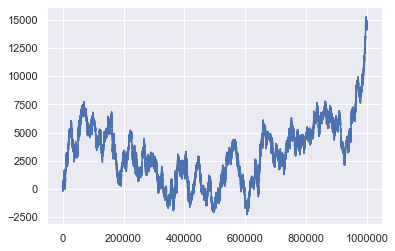

In [234]:
plt.plot(a1.reshape(1,1000000).real[0].cumsum())

In [136]:
a1.reshape(1,1000000).real[0]

array([ 0.00816656,  0.00648417,  0.00648417, ..., -0.00488283,
        0.00609178,  0.00609178])

In [16]:
def calc_diversification_ratio(w, V):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # portfolio vol
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio


#####################################################################
#               PORTFOLIO Optimization functions                    #
#####################################################################

def max_div_port(w0, V, bnd=None, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=V, method='SLSQP', constraints=cons)
    return res

In [6]:
A.fillna(0, inplace=True)
A.to_excel('SP500REALONE.xlsx')

In [11]:
interest_rates= pd.DataFrame() 
interest_rates=wb.DataReader('^TNX',data_source='yahoo',start='1960-01-31')['Adj Close']

In [13]:
interest_rates

Date
1962-01-02    4.060
1962-01-03    4.030
1962-01-04    3.990
1962-01-05    4.020
1962-01-08    4.030
              ...  
2020-04-03    0.587
2020-04-06    0.676
2020-04-07    0.736
2020-04-08    0.764
2020-04-09    0.729
Name: Adj Close, Length: 14546, dtype: float64

In [81]:
Comparative=['^GSPC','^OEX','^HSI','^N225']
C=pd.DataFrame()
C=wb.DataReader(Comparative,data_source='yahoo',start='1960-01-31')['Adj Close']
C=C.dropna().resample('1M').last()
Rt = np.log(C/C.shift(1)).dropna()

In [82]:
Rt

Symbols,^GSPC,^HSI,^N225,^OEX
Date,,,,
1987-02-28,0.031454,0.119674,0.031423,0.032856
1987-03-31,0.026048,-0.058711,0.054553,0.031988
1987-04-30,-0.011516,-0.020061,0.076224,0.004739
1987-05-31,0.006016,0.103788,0.062357,0.005454
1987-06-30,0.046802,0.074239,-0.024353,0.047994
1987-07-31,0.047097,0.090487,0.012811,0.042179
1987-08-31,0.025958,0.037376,0.058945,0.033271
1987-09-30,-0.016059,0.087915,0.001382,-0.021634
1987-10-31,-0.245428,-0.581593,-0.133289,-0.239843


In [83]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [93]:
A = (Rt.iloc[:,0]-Rt.iloc[:,0].shift(1)).dropna().values
B = Rt.iloc[:,0].shift(1).dropna().values

In [94]:
ts.adfuller(Rt.iloc[:,3])

(-18.934640042518705,
 0.0,
 0,
 405,
 {'1%': -3.446599953548936,
  '5%': -2.86870295908671,
  '10%': -2.570585643956714},
 -1341.525393519254)

In [96]:
res = sm.OLS(A,B).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.458
Model:                            OLS   Adj. R-squared (uncentered):              0.456
Method:                 Least Squares   F-statistic:                              340.9
Date:                Sat, 07 Nov 2020   Prob (F-statistic):                    1.23e-55
Time:                        15:48:33   Log-Likelihood:                          689.62
No. Observations:                 405   AIC:                                     -1377.
Df Residuals:                     404   BIC:                                     -1373.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [99]:
M = pd.read_csv('Desktop/backtest_trades_adeae124523d93b421f382af3563786c.csv')

In [102]:
M.index = M.Time 

In [109]:
M = M.drop(['Time'],axis=1)

In [110]:
M.index = pd.to_datetime(M.index)

In [121]:
M.mask(M.iloc[:,-1] == 'Liquidated')

,Symbol,Price,Quantity,Type,Status,Value,Tag
Time,,,,,,,
2003-01-01 05:00:00+00:00,COST,20.462170,-349,Market On Open,Filled,-7141.297422,
2003-01-01 05:00:00+00:00,AIG,783.810600,-9,Market On Open,Filled,-7054.295396,
2003-01-01 05:00:00+00:00,HD,16.224595,-443,Market On Open,Filled,-7187.495757,
2003-01-01 05:00:00+00:00,LOW,14.669913,-490,Market On Open,Filled,-7188.257470,
2003-01-01 05:00:00+00:00,KSS,39.483563,-181,Market On Open,Filled,-7146.524833,
2003-01-01 05:00:00+00:00,WMT,35.270097,-202,Market On Open,Filled,-7124.559616,
2003-01-01 05:00:00+00:00,AMGN,38.999179,-183,Market On Open,Filled,-7136.849842,
2003-01-01 05:00:00+00:00,COST,20.462170,698,Market On Open,Filled,14282.594844,
2003-01-01 05:00:00+00:00,AIG,783.810600,18,Market On Open,Filled,14108.590793,


In [127]:
M.mask(M.iloc[:,-1] == 'Liquidated')

,Symbol,Price,Quantity,Type,Status,Value,Tag
Time,,,,,,,
2003-01-01 05:00:00+00:00,COST,20.462170,-349,Market On Open,Filled,-7141.297422,
2003-01-01 05:00:00+00:00,AIG,783.810600,-9,Market On Open,Filled,-7054.295396,
2003-01-01 05:00:00+00:00,HD,16.224595,-443,Market On Open,Filled,-7187.495757,
2003-01-01 05:00:00+00:00,LOW,14.669913,-490,Market On Open,Filled,-7188.257470,
2003-01-01 05:00:00+00:00,KSS,39.483563,-181,Market On Open,Filled,-7146.524833,
2003-01-01 05:00:00+00:00,WMT,35.270097,-202,Market On Open,Filled,-7124.559616,
2003-01-01 05:00:00+00:00,AMGN,38.999179,-183,Market On Open,Filled,-7136.849842,
2003-01-01 05:00:00+00:00,COST,20.462170,698,Market On Open,Filled,14282.594844,
2003-01-01 05:00:00+00:00,AIG,783.810600,18,Market On Open,Filled,14108.590793,


In [131]:
M.Tag

AttributeError: 'DataFrame' object has no attribute 'Tag'

In [133]:
M == 'Liquidated'

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Symbol,Price,Quantity,Type,Status,Value,Tag
Time,,,,,,,
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
2003-01-01 05:00:00+00:00,False,False,False,False,False,False,False
